# Phase measurement tutorial

The goal of this tutorial is to introduce the **off-axis interferometry** technique, and one of its main applications: **phase retrieval**.

## Situation of the problem

We consider the following problem: assume that you have some field $E_s(\mathbf{r}_\perp, z)$ that you want to measure.

The problem is that, as usual, you can only measure $I_s(\mathbf{r}_\perp, z)=|E_s(\mathbf{r}_\perp, z)|^2$.

Is there a way to retrieve the **phase information** ?

This is actually a common problem in electronics and is used every day by your phone / radio: in order to retrieve the information encoded as phase modulation, you "listen" to the beating of this signal with a local oscillator whose frequency is known.

![mixer](assets/IdealMixer.png)

![heterodyne](assets/heterodyne.jpg)

This is called **heterodyning**.

Now this is in time domain (we'll come back to this !), but we would like to do this in spatial domain. 

We understand that we want a **product term**: how can we do that ?

## Off-axis interferometry

The solution to this conundrum is to beat the signal beam $E_s$ with a reference beam $E_r$. 

Let's look at a prototype setup:
![setup](assets/setup.png)

Now, assuming the two beams share the same polarization, and assuming the angle between the two beams is small enough to resolve the fringes on a camera, the signal on the camera is simply the interference pattern or:
$$
\begin{split}
    &I_{cam}(\textbf{r}_\perp)\propto|E_s(\textbf{r}_\perp)e^{i\phi(\mathbf{r}, z)}+E_r(\textbf{r}_\perp)e^{i\textbf{k}_r\textbf{r}_\perp}|^2=\\
    &
    \underbrace{I_s(\textbf{r})+I_r(\textbf{r})}_{\textrm{DC part}}+
    \underbrace{2\sqrt{I_s(\textbf{r}_\perp)I_r(\textbf{r}_\perp)} \textrm{cos}\left(\textbf{k}_r\textbf{r}_\perp+\phi(\textbf{r}_\perp)+\phi_0\right)}_{\textrm{modulated part}}
\end{split}
$$
where $k_r$ is the angle of the reference beam.

Now we anticipate without too much thinking that in order to demodulate the signal in the $\mathrm{cos}$, we'll need to Fourier transform this expression:
$$
\begin{split}
    &\tilde{I}_\text{cam} (\mathbf{k}_\perp) = \underbrace{\tilde{I}_\text{s} (\mathbf{k}_\perp) + \tilde{I}_\text{r} (\mathbf{k}_\perp)}_{0^{th}~order} +\\
    &\underbrace{
    \mathcal{F} \left[E_s e^{i\phi (\mathbf{r})} \right] (\mathbf{k}_\perp) *
    \left\{\tilde{E}_r(\mathbf{k}_\perp - \mathbf{k}_r)  + \tilde{E}_r(\mathbf{k}_\perp + \mathbf{k}_r) \right\}}_{1^{st}~order}
\end{split}
$$
Now we see that the relevant terms are in the first order. 

There is a bothersome convolution however ...

![convol](assets/convolution_anim.gif)

But let's look a bit at the functions involved: the reference beam will be a gaussian beam. Assuming it's big and has a flat phase, its Fourier transform will be a very small gaussian. Thus if it's much bigger than the signal beam, we can say it's a Dirac ! 

Plugging $\tilde{E}_s(\mathbf{k}_\perp)\propto \delta(\mathbf{k}_\perp)$ we see finally that the Fourier transform of the signal is merely **shifted** in Fourier domain into **two symetrical directions** at $\pm \mathbf{k}_r$ !

This is a typical result from off-axis holography [1]

[1]: https://opg.optica.org/view_article.cfm?pdfKey=07483157-0e25-4616-86c9663808987b0f_62321

![holography](assets/holography.png)

We thus see that the signal in Fourier domain becomes:
$$
\begin{split}
&\tilde{I}_\text{cam} (\mathbf{k}_\perp) \approx \underbrace{\tilde{I}_\text{s} (\mathbf{k}_\perp) + \tilde{I}_\text{r} (\mathbf{k}_\perp)}_{0^{th}~order} +\\
&\underbrace{
\mathcal{F} \left[E_s e^{i\phi (\mathbf{r})} \right] (\mathbf{k}_\perp+\mathbf{k}_r)+
\mathcal{F} \left[E_s e^{i\phi (\mathbf{r})} \right] (\mathbf{k}_\perp-\mathbf{k}_r)}_{1^{st}~order}
\end{split}
$$

If we filter one of the first order terms, and shift the signal in Fourier domain from $-\mathbf{k}_r$ to get rid of the off-axis term, by back transforming we simply recover:
$$
E_s e^{i\phi (\mathbf{r}_\perp)} * \mathcal{F}^{-1}\left[\tilde{T}\right](\mathbf{r}_\perp)
$$
Where $\tilde{T}(\mathbf{k}_\perp)$ is the function we used to filter the first order in the Fourier domain. If $\tilde{T}(\mathbf{k}_\perp)$ was a circle, $\mathcal{F}^{-1}\left[\tilde{T}\right](\mathbf{r}_\perp)$ will be an Airy function. The meaning of this is that it is not magical: the recovery process will deteriorate the spatial resolution of the recovered field.

The goal is thus to try and chose the **largest** selection region possible, while still **rejecting** the first order.

## Python implementation

We'll now see a bit how we can test this in Python.

First step is to simulate both beams.

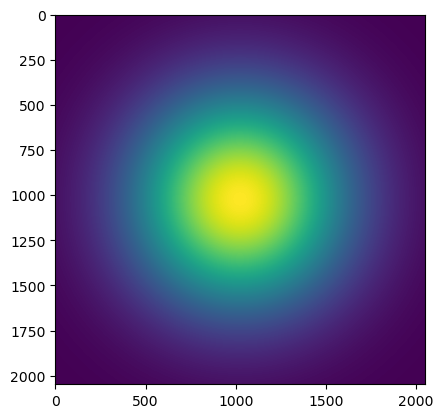

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import contrast
from scipy import ndimage

np.random.seed(1)

window = 7e-3
N = 2048
x = np.linspace(-window/2, window/2, N)
xx, yy = np.meshgrid(x, x)
w_signal = 2e-3
w_ref = 8e-3
# define signal beam
signal = np.exp(-(xx**2+yy**2)/w_signal**2)
plt.imshow(signal)


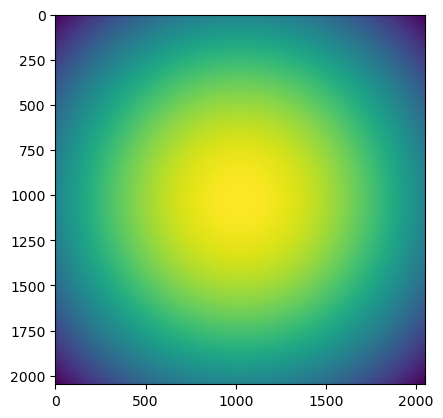

In [5]:
# define reference beam
ref = np.exp(-(xx**2+yy**2)/w_ref**2)
plt.imshow(ref)

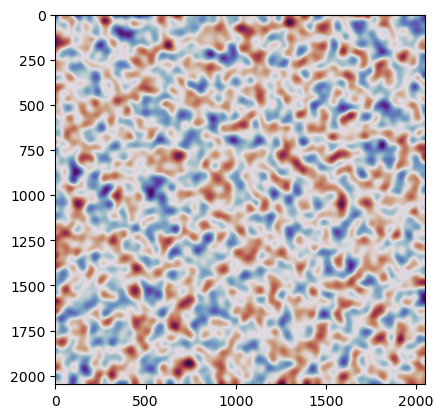

In [6]:
# define spatial frequencies
k = np.fft.fftfreq(N, x[1]-x[0])
# half the max frequency
k_angle = np.pi*k[N//2]
phi_angle = k_angle*(xx + yy)
# define signal phase
phi_signal = 2*np.random.random((N, N))-1
phi_signal = ndimage.gaussian_filter(phi_signal, 20)
phi_signal /= np.max(phi_signal)
phi_signal *= np.pi
plt.imshow(phi_signal, vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted')


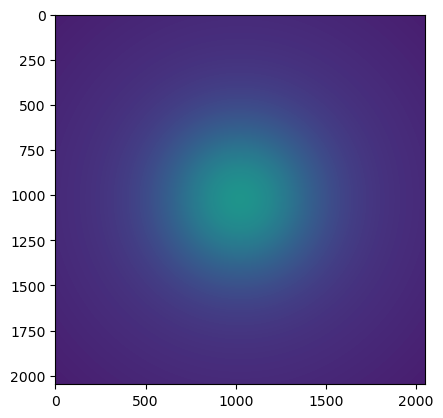

In [7]:
# contrast of the fringes
cont = 0.5
interf = signal*np.exp(1j*phi_signal) + np.sqrt(cont)*ref*np.exp(1j*phi_angle)
i_interf = np.abs(interf)**2
plt.imshow(i_interf)


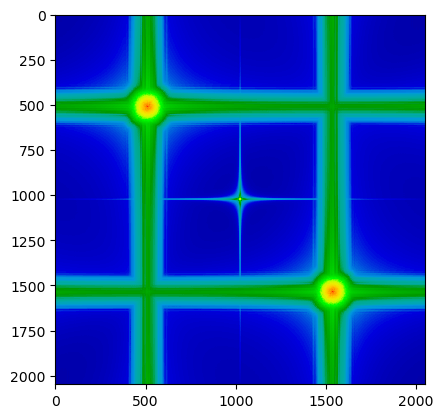

In [8]:
# let's look at what this gives in Fourier domain
i_interf_fft = np.abs(np.fft.fftshift(np.fft.fft2(i_interf)))
plt.imshow(np.log10(i_interf_fft), cmap='nipy_spectral')


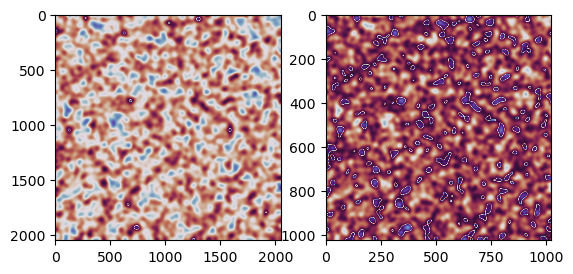

In [17]:
# use contrast phase fast to recover phase
phi_reconstruct = contrast.phase_fast(i_interf)
recons = contrast.im_osc_fast_t(i_interf)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(phi_reconstruct, vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted')
ax[1].imshow(np.angle(recons), cmap='twilight_shifted')


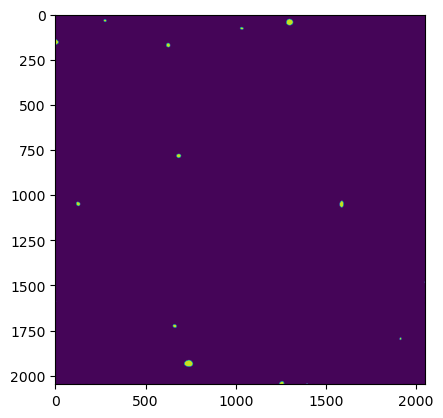

In [10]:
# we want to know how good is the recovery
err = np.abs(phi_reconstruct-phi_signal)**2
plt.imshow(err)

In [11]:
# compute standard deviation to get a single number
err_std = np.std(err)
err_std**2

1.174246332136923

## Details of `contrast.py`

So this looks convincing enough but how exactly should we implement it ?

Let us start with the interferogram that we have Fourier transformed:

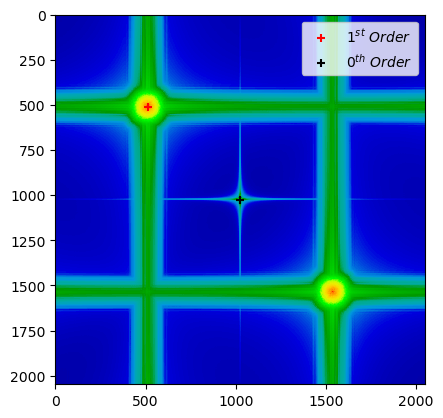

In [12]:
plt.imshow(np.log10(i_interf_fft), cmap='nipy_spectral')
plt.scatter(512, 512, color='red', marker='+', label=r'$1^{st}~Order$')
plt.scatter(1024, 1024, color='k', marker='+', label=r'$0^{th}~Order$')
plt.legend()

### Sampling region

**NOW COMES THE VERY IMPORTANT PART !!**

As mentioned before, we want to have the best resolution possible.

In order to do this we need to select the biggest possible region while still rejecting the 0th order.

The easiest and most general way to do this, is to simply define a circle whose radius is $N/4$ is $(N,N)$ is the size of the image.

**WHY ?**

We want to keep an isotropic resolution so we need a circle. And furthermore we cannot go above $N//4$ because we'll start to "bleed" into the other orders and introduce artificial information.

Symetrically, when setting up such an off-axis interferometer, you **MUST** follow this rule ! This means you need to set up the angle such that the fringes fulfill this optimal sampling condition. This way, you can get the best tradeoff between spatial resolution and phase resolution.

A helper function for your experiments is available: `monitor_fourier_fringes`

/tmp/ipykernel_810664/3846352290.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(i_interf_fft), cmap='nipy_spectral')


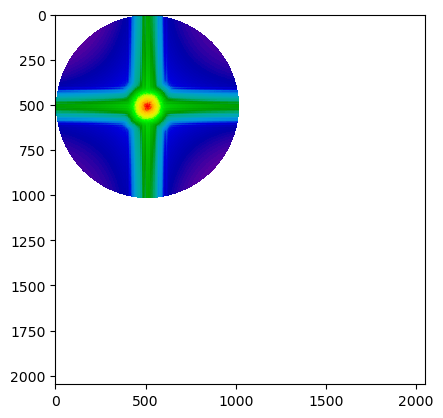

In [13]:
# define position grod
Ny, Nx = i_interf_fft.shape
# define center of 1st order
center = Nx//4, Ny//4
radius = Nx//4
Y, X = np.ogrid[:Ny, :Nx]
dist_from_center = np.hypot(X - center[0], Y-center[1])
# filter everything that is outside the radius
mask = dist_from_center > radius
i_interf_fft[mask] = 0
plt.imshow(np.log10(i_interf_fft), cmap='nipy_spectral')

### Suppression of the off-axis component

Now we would be tempted to directly back transform the selected part.

However this would yield something like this:

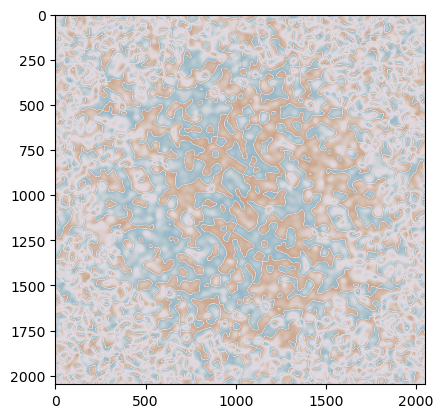

In [14]:
i_interf_ifft = np.fft.fftshift(np.fft.ifft2(i_interf_fft))
plt.imshow(np.angle(i_interf_ifft), cmap='twilight_shifted')

We have a set of very **high frequency fringes**: this is the **off-axis** component stemming from the angle between reference and signal arms $\propto \mathbf{k}_r\cdot\mathbf{r}$.

In order to get rid of this, one simply has to shift the selected first order to the center of the image:

/tmp/ipykernel_810664/1643286901.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(i_interf_ifft), cmap='nipy_spectral')


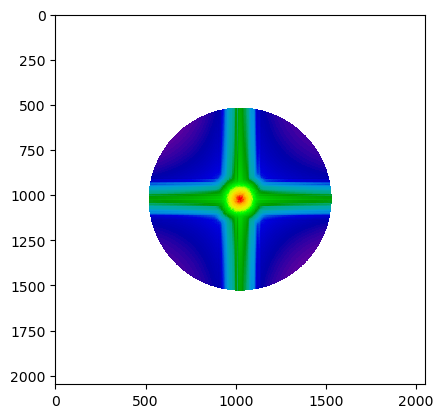

In [15]:
i_interf_ifft = np.roll(i_interf_fft, (Ny//4, Nx//4), axis=(0, 1))
plt.imshow(np.log10(i_interf_ifft), cmap='nipy_spectral')

Now if we back-transform:

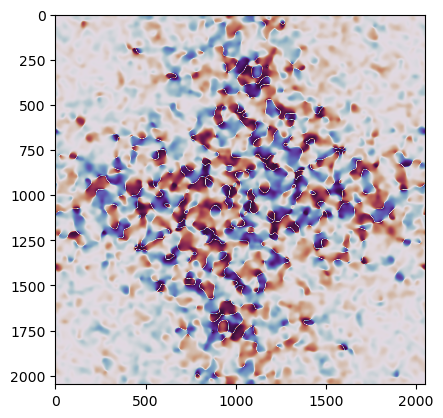

In [16]:
i_interf_ifft = np.fft.ifft2(np.fft.fftshift(i_interf_ifft))
plt.imshow(np.angle(i_interf_ifft), cmap='twilight_shifted')

We notice that we recover the signal with a bit of aliasing.
Now let's see how we can make it fast to bring it to the lab !

### Need for speed: `im_osc_fast` implementation

Several points: 
- Since we deal with a real signal at first, why bother using a full FFT when we can use a real FFT and compute only half of the coeffs ?
- Since we end up with half the resolution, why recast into a whole $(N, N)$ image ? 
- Numpy FFT is slow, is there anything faster out there ?

Let's have a look at how we solve these problems:
- Real transform and slow FFT : `pyFFTW` using `pyfftw.interfaces.numpy_fft.rfft2`. We also take advantage of caching and multithreading by saving and loading a "wisdom" file that will save the most efficient plans for FFT computations.
- Recast the selected first order to a halved matrix $(N/2, N/2)$
- Define compiled kernels with numba for the expensive complex argument calculation


```python
def im_osc_fast(im: np.ndarray, radius: int = 0, cont: bool = False) -> np.ndarray:
    """Fast field recovery assuming ideal reference angle i.e minimum fringe size of sqrt(2) pixels

    Args:
        im (cp.ndarray): Interferogram
        radius (int, optional): Radius of filter in px. Defaults to 512.
        return_cont (bool, optionnal): Returns the continuous part of the field. Defaults to False.

    Returns:
        np.ndarray: Recovered field
    """
    if radius == 0:
        radius = min(im.shape)//4
    center = (im.shape[0]//4, im.shape[1]//4)
    assert len(im.shape) == 2, "Can only work with 2D images !"
    # center of first quadran
    im_ifft = pyfftw.zeros_aligned(
        (im.shape[0], im.shape[1]), dtype=np.complex64)
    im_fft = pyfftw.interfaces.numpy_fft.rfft2(im)
    Y, X = np.ogrid[:im_fft.shape[0], :im_fft.shape[1]]
    dist_from_center = np.hypot(X - center[0], Y-center[1])
    mask = dist_from_center > radius
    if cont:
        cont_size = int((np.sqrt(2)-1)*radius)
        im_ifft_cont = pyfftw.empty_aligned(
            (im.shape[0], im.shape[1]//2+1), dtype=np.complex64)
        mask_cont = cache(cont_size, out=False, center=(0, 0),
                          nb_pix=im_ifft_cont.shape)
        mask_cont = np.logical_xor(mask_cont,
                                   cache(cont_size, out=False,
                                         center=(0, im_ifft_cont.shape[0]),
                                         nb_pix=im_ifft_cont.shape))
        im_ifft_cont[0:im_ifft_cont.shape[0]//2,
                     :] = im_fft[0:im_ifft_cont.shape[0]//2, 0:im_ifft_cont.shape[1]]
        im_ifft_cont[im_ifft_cont.shape[0]//2:,
                     :] = im_fft[im_fft.shape[0]-im_ifft_cont.shape[0]//2:im_fft.shape[0],
                                 0:im_ifft_cont.shape[1]]
        im_ifft_cont[np.logical_not(mask_cont)] = 0
        im_cont = pyfftw.interfaces.numpy_fft.irfft2(im_ifft_cont)
    im_fft[mask] = 0
    im_ifft[im_ifft.shape[0]//2-radius:im_ifft.shape[0]//2+radius,
            im_ifft.shape[0]//2-radius:im_ifft.shape[0]//2+radius] = im_fft[
        center[1]-radius:center[1]+radius, center[0]-radius:center[0]+radius]
    im_ifft = np.fft.fftshift(im_ifft)
    im_ifft = pyfftw.interfaces.numpy_fft.ifft2(im_ifft)
    im_ifft *= np.exp(-1j *
                      np.angle(im_ifft[im_ifft.shape[0]//2, im_ifft.shape[1]//2]))
    if cont:
        return im_cont, im_ifft
    return im_ifft
```

For the phase:
```python
@numba.njit(numba.float32[:, :](numba.complex64[:, :]), fastmath=True,
            cache=True, parallel=True)
def angle_fast(x: np.ndarray) -> np.ndarray:
    """Accelerates a smidge angle by using fastmath

    Args:
        x (np.ndarray): The complex field

    Returns:
        np.ndarray: the argument of the complex field
    """
    out = np.empty_like(x, dtype=np.float32)
    for i in numba.prange(x.shape[0]):
        for j in range(x.shape[1]):
            out[i, j] = cmath.phase(x[i, j])
    return out

def phase_fast(im: np.ndarray, radius: int = 0, cont: bool = False) -> np.ndarray:
    """Fast phase recovery assuming ideal reference angle

    Args:
        im (np.ndarray): Interferogram
        radius (int, optional): Radius of filter in px. Defaults to a quarter the size of the image.
        return_cont (bool, optionnal): Returns the continuous part of the field. Defaults to false.

    Returns:
        np.ndarray: Recovered phase
    """
    if cont:
        im_ifft, im_cont = im_osc_fast_t(im, radius=radius, cont=True)
        phase = angle_fast(im_ifft)
        return phase, im_cont
    im_ifft = im_osc_fast_t(im, radius=radius, cont=False)
    phase = angle_fast(im_ifft)
    return phase
```

Finally for ultimate speed, you should use the GPU with the `_cp` versions of the aforementioned functions.

## In practice: how do I do in the lab ??

Simple to do list:
- Get two beams to interfere on a NPBS
- **Check polarization for optimal contrast**. Balance the two arms power.
- Go to 0 order (teinte plate) to get optimal alignment
- Slowly move the reference arm angle to increase the number of fringes, trying to keep them diagonal. Be careful to maintain overlap of the two beams.
- Open the `monitor_fourier_fringes` viewer
- Move the reference beam angle until the first order spot (seen as a bright yellow spot) is centered on the red cross
- Check beam superposition
- Close the `monitor_fourier_fringes` viewer, open the `monitor_phase` viewer and check that you have a flat phase and contrast everywhere on the screen.
  
Normally, as the reference beam is much larger than the  signal one, and that the two arms are balanced (maximum contrast), you should see contrast over the whole screen. If the contrast seems non uniform (there is only a region of the image where phase is gibberish), check beam superposition. This can be done by using the `monitor_phase` viewer:
- Adjust the reference arm position in order to get a uniform contrast
- Compensate angle to recover a flat phase
- Repeat the last 2 steps until good contrast is reached everywhere